## 01. Persiapan

### Import Library

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import shap
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")

### Helper

In [3]:
def metrik(y_true, y_pred, y_prob):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  roc = roc_auc_score(y_true, y_prob)
  return acc, prec, rec, f1, roc


## 02. Persiapan dan Pemahaman Data

### Load Dataset

In [4]:
df = pd.read_csv("./data/loan.csv",low_memory=False)
# df = pd.read_parquet("./data/loan05.parquet.gzip")

### Dataset

##### Dimensi

In [5]:
df.shape

(2260668, 145)

##### Informasi Tipe Data dan Nilai Non-Null

In [6]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 145 columns):
 #    Column                                      Non-Null Count    Dtype  
---   ------                                      --------------    -----  
 0    id                                          0 non-null        float64
 1    member_id                                   0 non-null        float64
 2    loan_amnt                                   2260668 non-null  int64  
 3    funded_amnt                                 2260668 non-null  int64  
 4    funded_amnt_inv                             2260668 non-null  float64
 5    term                                        2260668 non-null  object 
 6    int_rate                                    2260668 non-null  float64
 7    installment                                 2260668 non-null  float64
 8    grade                                       2260668 non-null  object 
 9    sub_grade                                   

##### Statistik Deskriptif untuk Fitur Numerik

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,2260668.0,15046.931228,9190.245488,500.00,8000.00,12900.000,20000.0000,40000.00
funded_amnt,2260668.0,15041.664057,9188.413022,500.00,8000.00,12875.000,20000.0000,40000.00
funded_amnt_inv,2260668.0,15023.437624,9192.331807,0.00,8000.00,12800.000,20000.0000,40000.00
...,...,...,...,...,...,...,...,...
hardship_payoff_balance_amount,10613.0,11628.036442,7615.161123,55.73,5628.73,10044.220,16114.9400,40306.41
hardship_last_payment_amount,10613.0,193.606331,198.694368,0.01,43.78,132.890,284.1800,1407.86
settlement_amount,33056.0,5030.606922,3692.027842,44.21,2227.00,4172.855,6870.7825,33601.00
settlement_percentage,33056.0,47.775600,7.336379,0.20,45.00,45.000,50.0000,521.35


##### Statistik Deskriptif untuk Fitur Kategorikal

In [8]:
df.describe(include='object').T

,count,unique,top,freq
term,2260668,2,36 months,1609754
grade,2260668,7,B,663557
sub_grade,2260668,35,C1,145903
emp_title,2093699,512694,Teacher,38824
emp_length,2113761,11,10+ years,748005
home_ownership,2260668,6,MORTGAGE,1111450
verification_status,2260668,3,Source Verified,886231
issue_d,2260668,139,Mar-2016,61992
loan_status,2260668,9,Fully Paid,1041952
pymnt_plan,2260668,2,n,2259986


##### Analisis Variabel Target

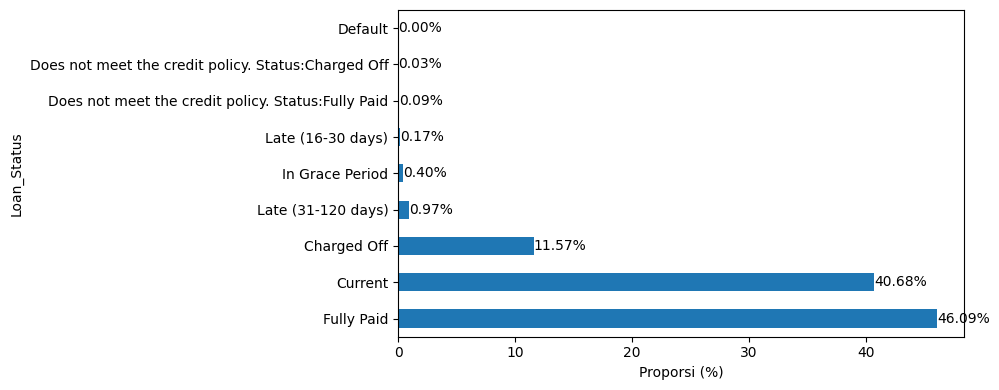

In [15]:
loan_status_counts = df['loan_status'].value_counts(normalize=True) * 100
plt.figure(figsize=(10, 4))
ax = loan_status_counts.plot(kind='barh')

# Menambahkan label pada setiap batang
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

# plt.title('Perbandingan Distribusi Status Pinjaman')
plt.xlabel('Proporsi (%)')
plt.ylabel('Loan_Status')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Feature Engineering & Preprocessing

##### Penentuan variabel target

In [16]:
statuses = [
    'Fully Paid',
    'Charged Off'
]
df = df.loc[df['loan_status'].isin(statuses)].copy()

##### Feature Engineering: lama pinjaman

In [17]:
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
years_diff = (pd.to_datetime('2019-02-01', yearfirst='True').year - df['issue_d_date'].dt.year)
months_diff = (pd.to_datetime('2019-02-01', yearfirst='True').month - df['issue_d_date'].dt.month)
df['credit_duration'] = years_diff * 12 + months_diff
df['credit_duration'] = df['credit_duration'].astype(int)

##### Feature Engineering: historis pinjaman terakhir

In [18]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
years_diff_earliest = (pd.to_datetime('2019-02-01', yearfirst='True').year - df['earliest_cr_line_date'].dt.year.fillna(0))
months_diff_earliest = (pd.to_datetime('2019-02-01', yearfirst='True').month - df['earliest_cr_line_date'].dt.month.fillna(0))
df['earliest_credit_duration'] = years_diff_earliest * 12 + months_diff_earliest
df['earliest_credit_duration'] = df['earliest_credit_duration'].astype(int)

##### Drop atribut hasil proses Feature Engineering

In [19]:
att_drop = ['issue_d','issue_d_date','earliest_cr_line','earliest_cr_line_date']
df = df.drop(columns=att_drop)

In [20]:
df.shape

(1303607, 145)

##### Drop atribut: Unique Values <= 1

In [9]:
def count_unique_values(df_data):
  unique_counts = []
  for col in df_data.columns:
    unique_counts.append({'Column_Name': col, 'Unique_Value_Count': df_data[col].nunique()})
  return pd.DataFrame(unique_counts)

df_unique = count_unique_values(df)
columns_to_drop = df_unique.loc[df_unique['Unique_Value_Count'] <= 1]['Column_Name'].tolist()
df = df.drop(columns=columns_to_drop)

In [10]:
df.shape

(1303607, 134)

In [11]:
att_leakage = ['hardship_flag', 'hardship_reason', 'hardship_status', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'hardship_dpd', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'last_pymnt_d','last_pymnt_amnt','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','last_credit_pull_d','recoveries','collection_recovery_fee','debt_settlement_flag','debt_settlement_flag_date','settlement_status','settlement_date','settlement_amount','settlement_percentage','settlement_term']
df[att_leakage]
df = df.drop(columns=att_leakage)

In [12]:
df.shape

(1303607, 107)

In [13]:
def cek_null(df_data):
  nan_counts = df_data.isnull().sum()
  nan_proportions = (nan_counts / len(df_data)) * 100

  nan_info = pd.DataFrame({
      'NaN_Count': nan_counts,
      'NaN_Proportion': nan_proportions
  })
  return nan_info.sort_values(by='NaN_Count', ascending=False)

df_cek_null = cek_null(df)
columns_to_drop = df_cek_null.loc[df_cek_null['NaN_Proportion'] >= 10].index.tolist()
df = df.drop(columns=columns_to_drop, errors='ignore')

In [14]:
df.shape

(1303607, 70)

In [15]:
att_drop = ['emp_title', 'title', 'zip_code', 'addr_state']
df = df.drop(columns=att_drop)

In [16]:
df.shape

(1303607, 66)

In [29]:
# df.to_parquet("./data/loan_clean_04.parquet.gzip", compression='gzip')
df = pd.read_parquet("./data/loan_clean_04.parquet.gzip")

In [17]:
df['term'] = pd.to_numeric(df['term'].str.replace(' months', ''))
df['grade'] = pd.to_numeric(df['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}))
df['sub_grade']= pd.to_numeric(df['sub_grade'].str.replace('A', '1').str.replace('B', '2').str.replace('C', '3').str.replace('D', '4').str.replace('E', '5').str.replace('F', '6').str.replace('G', '7'))
df['home_ownership'] = pd.to_numeric(df['home_ownership'].map({'MORTGAGE': 1, 'RENT': 2, 'OWN': 3, 'ANY': 4, 'OTHER': 5, 'NONE': 0}))
df['verification_status'] = pd.to_numeric(df['verification_status'].map({'Verified': 1, 'Source Verified': 2, 'Not Verified': 0}))
df['purpose'] = pd.to_numeric(df['purpose'].map({'debt_consolidation':1, 'credit_card':2, 'home_improvement':3, 'other':0, 'major_purchase':4, 'medical':5, 'small_business':6, 'car':7, 'moving':8, 'vacation':9, 'house':10, 'wedding':11, 'renewable_energy':12, 'educational':13}))
df['emp_length'] = pd.to_numeric(df['emp_length'].map({ '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10 }))
df['emp_length'] = df['emp_length'].fillna(11)
df['initial_list_status'] = pd.to_numeric(df['initial_list_status'].map({'w':1, 'f':0}))
df['disbursement_method'] = pd.to_numeric(df['disbursement_method'].map({'Cash':1, 'DirectPay':0}))
df['application_type'] = pd.to_numeric(df['application_type'].map({'Individual':1, 'Joint App':0}))
df['loan_status'] = pd.to_numeric(df['loan_status'].map({'Fully Paid':0, 'Charged Off':1}))

## Load Data (Fast Track)

In [34]:
# df.to_parquet("./data/loan_clean_05.parquet.gzip", compression='gzip')
df = pd.read_parquet("./data/loan_clean_05.parquet.gzip")

### Split Train - Test

In [35]:
%%time
# Split
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

CPU times: total: 1 s
Wall time: 991 ms


In [36]:
# Hitung proporsi kelas di dataset asli
original_distribution = y.value_counts(normalize=True) * 100
print("Distribusi Dataset Asli:")
print(original_distribution.round(2))

Distribusi Dataset Asli:
loan_status
0    79.93
1    20.07
Name: proportion, dtype: float64


In [37]:
# Hitung proporsi di train set
train_distribution = y_train.value_counts(normalize=True) * 100

# Hitung proporsi di test set
test_distribution = y_test.value_counts(normalize=True) * 100

print("\nDistribusi Train Set:")
print(train_distribution.round(2))
print("\nDistribusi Test Set:")
print(test_distribution.round(2))


Distribusi Train Set:
loan_status
0    79.93
1    20.07
Name: proportion, dtype: float64

Distribusi Test Set:
loan_status
0    79.93
1    20.07
Name: proportion, dtype: float64


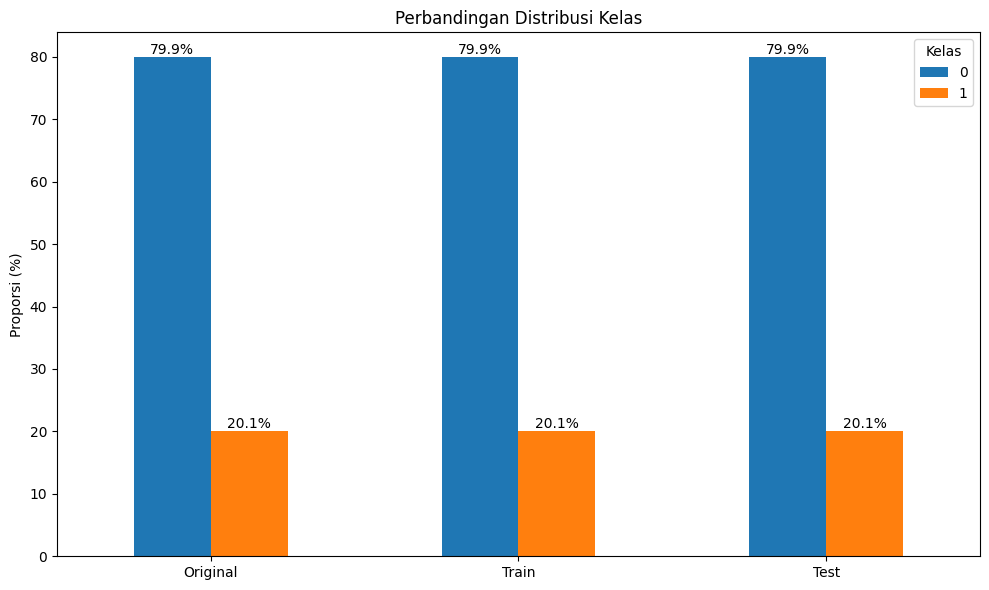

In [48]:

# Gabungkan hasil ke DataFrame untuk visualisasi
dist_df = pd.DataFrame({
    'Original': original_distribution,
    'Train': train_distribution,
    'Test': test_distribution
}).T

# Plot
# dist_df.plot(kind='bar', stacked=False, figsize=(10, 6))

ax = dist_df.plot(kind='bar', stacked=False, figsize=(10, 6))
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Perbandingan Distribusi Kelas')
plt.ylabel('Proporsi (%)')
plt.xticks(rotation=0)
plt.legend(title='Kelas')
plt.tight_layout()
plt.show()

In [40]:
# Model
lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,  # ≈ 2^5 - 1, lebih sesuai dengan filosofi LightGBM
    random_state=42,
    verbose=-1,
)
lgbm_model.fit(X_train, y_train)
# importances = lgbm_model.feature_importances_
booster = lgbm_model.booster_
gain_importance = booster.feature_importance(importance_type='gain')

df_feature_importance_LightGBM = pd.DataFrame({
    'fitur': X_train.columns,
    'importance': gain_importance
    # 'importance': importances
}).sort_values(by='importance', ascending=False)

df_feature_importance_LightGBM.loc[df_feature_importance_LightGBM['importance'] > 0].head()

,fitur,importance
7,sub_grade,555946.066425
6,grade,201321.242851
63,credit_duration,103576.186146
3,term,64273.864731
29,avg_cur_bal,31713.826275


### Correlation Matrix

In [41]:
%%time
# Buat correlation matrix
correlation_matrix = df.corr()

# Tampilkan correlation matrix
# correlation_matrix

CPU times: total: 7 s
Wall time: 7.03 s


### Feature Importance Model Based vs Correlation

In [42]:
# Temukan fitur yang berkorelasi tinggi (di atas ambang batas)
threshold = 0.85
high_corr_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.add((colname_i, colname_j))

# Konversi set pasangan ke list untuk pemrosesan yang lebih mudah
high_corr_list = list(high_corr_pairs)

# Urutkan pasangan fitur berdasarkan importance_gain (dari terendah ke tertinggi)
# Kita akan menghapus fitur dengan importance_gain yang lebih rendah dalam pasangan yang berkorelasi tinggi

features_to_drop = set()
for feature1, feature2 in high_corr_list:
    # Dapatkan importance_gain untuk kedua fitur
    gain1 = df_feature_importance_LightGBM[df_feature_importance_LightGBM['fitur'] == feature1]['importance'].values[0]
    gain2 = df_feature_importance_LightGBM[df_feature_importance_LightGBM['fitur'] == feature2]['importance'].values[0]

    # Bandingkan dan tambahkan fitur dengan gain yang lebih rendah ke daftar drop
    if gain1 < gain2:
        features_to_drop.add(feature1)
    else:
        features_to_drop.add(feature2)

# Hapus fitur dari df_feature_importance_LightGBM
df_feature_importance_LightGBM_reduced = df_feature_importance_LightGBM[~df_feature_importance_LightGBM['fitur'].isin(features_to_drop)].reset_index(drop=True)

print("Fitur yang Dieliminasi:")
print(features_to_drop)

print("\nDataFrame Feature Importance setelah Eliminasi:")
df_feature_importance_LightGBM_reduced.head()

Fitur yang Dieliminasi:
{'int_rate', 'funded_amnt', 'funded_amnt_inv', 'open_acc', 'num_rev_tl_bal_gt_0', 'bc_util', 'total_bal_ex_mort', 'earliest_credit_duration', 'installment', 'grade', 'tot_cur_bal'}

DataFrame Feature Importance setelah Eliminasi:


,fitur,importance
0,sub_grade,555946.066425
1,credit_duration,103576.186146
2,term,64273.864731
3,avg_cur_bal,31713.826275
4,dti,31219.768425


In [43]:
# df_feature_importance_LightGBM_reduced['fitur'].head(20).to_list()
df_feature_importance_LightGBM_reduced.loc[df_feature_importance_LightGBM_reduced['importance'] > 0].head()

,fitur,importance
0,sub_grade,555946.066425
1,credit_duration,103576.186146
2,term,64273.864731
3,avg_cur_bal,31713.826275
4,dti,31219.768425


## MAIN

### Tanpa SHAP

#### Tanpa ADASYN

In [14]:
%%time
# cols_list = df_feature_importance_LightGBM_reduced['fitur'].head(20).to_list()
cols_list = df_feature_importance_LightGBM_reduced.loc[df_feature_importance_LightGBM_reduced['importance'] > 0]['fitur'].to_list()

for length in range(1, len(cols_list)+1):
# for length in range(10, 16):
  start = time.perf_counter()
  cols = cols_list[:length]
  X = df[cols]
  y = df['loan_status']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  counts = np.bincount(y_train)
  scale_pos_weight = counts[0] / counts[1]
  # --- Model 1: LightGBM ---
  lgbm_model = LGBMClassifier(
      random_state=42,
      n_jobs=-1,
      objective='binary', # Tentukan objective untuk klasifikasi biner
      is_unbalance=True,
      verbose=-1,
  )
  # Latih model pada data yang sudah di-resample
  lgbm_model.fit(X_train_scaled, y_train)
  y_pred_lgbm = lgbm_model.predict(X_test_scaled)
  y_prob_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]

  acc, prec, rec, f1, roc = metrik(y_test, y_pred_lgbm, y_prob_lgbm,'LightGBM')
  dur = time.perf_counter() - start
  print(f"Iterasi {length}:\t{acc:.4f}\t{prec:.4f}\t{rec:.4f}\t{f1:.4f}\t{roc:.4f}\t{dur:.4f} s")
  with open('hasil03.txt', 'a') as file:
    file.write(f"NO_SHAP_NO_ADASYN\t{length}\t{acc:.4f}\t{prec:.4f}\t{rec:.4f}\t{f1:.4f}\t{roc:.4f}\t{dur:.4f} s\n")


Iterasi 1:	0.6046	0.2935	0.6890	0.4116	0.6874	0.9998 s
Iterasi 2:	0.6205	0.3031	0.6854	0.4203	0.6990	1.0221 s
Iterasi 3:	0.6359	0.3112	0.6710	0.4252	0.7055	1.0147 s
Iterasi 4:	0.6400	0.3149	0.6750	0.4294	0.7116	1.1773 s
Iterasi 5:	0.6435	0.3175	0.6750	0.4318	0.7149	1.2692 s
Iterasi 6:	0.6455	0.3193	0.6767	0.4338	0.7169	1.3115 s
Iterasi 7:	0.6468	0.3204	0.6778	0.4351	0.7187	1.4294 s
Iterasi 8:	0.6496	0.3223	0.6767	0.4367	0.7202	1.5026 s
Iterasi 9:	0.6500	0.3229	0.6780	0.4375	0.7211	1.6081 s
Iterasi 10:	0.6509	0.3238	0.6788	0.4384	0.7224	1.5889 s
Iterasi 11:	0.6511	0.3242	0.6809	0.4393	0.7237	1.6580 s
Iterasi 12:	0.6531	0.3261	0.6825	0.4413	0.7266	1.7335 s
Iterasi 13:	0.6543	0.3270	0.6824	0.4421	0.7274	1.9114 s
Iterasi 14:	0.6556	0.3278	0.6814	0.4427	0.7284	2.0521 s
Iterasi 15:	0.6570	0.3288	0.6807	0.4434	0.7291	2.1734 s
Iterasi 16:	0.6571	0.3289	0.6810	0.4436	0.7295	2.1895 s
Iterasi 17:	0.6578	0.3294	0.6808	0.4440	0.7300	2.1986 s
Iterasi 18:	0.6573	0.3292	0.6819	0.4440	0.7301	2.3233 s
I

#### ADASYN

##### Handle Null Values

In [15]:
# Find columns with null values
cols_with_nulls = df.isnull().sum()
cols_with_nulls = cols_with_nulls[cols_with_nulls > 0].index.tolist()

# Fill null values with the median of each column using the recommended method
for col in cols_with_nulls:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

In [14]:
df_clean = df.dropna().copy()

##### Iteratif

In [15]:
cols_list = df_feature_importance_LightGBM_reduced.loc[df_feature_importance_LightGBM_reduced['importance'] > 0]['fitur'].to_list()

for length in range(1, len(cols_list)+1):
# for length in range(10, 15):
  start = time.perf_counter()
  cols0 = cols_list[:length]
  # cols = cols_list[:length] + ['loan_status']
  # df_clean = df[cols].copy()
  # df_clean = df_clean.dropna().copy()
  X = df_clean[cols0]
  y = df_clean['loan_status']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  adasyn = ADASYN(random_state=42, sampling_strategy='auto', n_neighbors=5)
  X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

  scaler = StandardScaler()
  X_resampled_scaled = scaler.fit_transform(X_resampled)
  X_test_scaled = scaler.transform(X_test)

  scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
  # --- Model 1: LightGBM ---
  lgbm_model = LGBMClassifier(
      random_state=42,
      n_jobs=-1,
      objective='binary', # Tentukan objective untuk klasifikasi biner
      scale_pos_weight=scale_pos_weight,
      # pos_bagging_fraction=0.9,
      # neg_bagging_fraction=0.3,
      # bagging_freq=1,
      min_child_samples=5,
      num_leaves=63,
      max_depth=10,
      # lambda_l1=0.01,
      # lambda_l2=0.01,
      # min_gain_to_split=0.0,
      # metric='recall',
      # is_unbalance=False, # Data sudah di-resample, jadi set ke False
      verbose=-1,
  )
  # Latih model pada data yang sudah di-resample
  lgbm_model.fit(
    X_resampled_scaled, 
    y_resampled,
    # eval_set=[(X_test_scaled, y_test)],
    # eval_metric='auc',
    # callbacks=[early_stopping(50)],
    )

  y_pred_lgbm = lgbm_model.predict(X_test_scaled)
  y_prob_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]

  acc, prec, rec, f1, roc = metrik(y_test, y_pred_lgbm, y_prob_lgbm,'LightGBM')
  dur = time.perf_counter() - start
  print(f"Iterasi {length}:\t{acc:.4f}\t{prec:.4f}\t{rec:.4f}\t{f1:.4f}\t{roc:.4f}\t{dur:.4f} s")
  with open('hasil03.txt', 'a') as file:
    file.write(f"NO_SHAP_ADASYN\t{length}\t{acc:.4f}\t{prec:.4f}\t{rec:.4f}\t{f1:.4f}\t{roc:.4f}\t{dur:.4f} s\n")

Iterasi 19:	0.6403	0.3205	0.7136	0.4424	0.7316	67.1227 s
Iterasi 20:	0.6423	0.3216	0.7113	0.4430	0.7326	81.1145 s
Iterasi 21:	0.6413	0.3213	0.7135	0.4431	0.7325	106.8011 s
Iterasi 22:	0.6423	0.3219	0.7128	0.4435	0.7330	139.2013 s
Iterasi 23:	0.6418	0.3218	0.7144	0.4437	0.7332	144.9599 s
Iterasi 24:	0.6418	0.3216	0.7134	0.4434	0.7330	181.5680 s
Iterasi 25:	0.6421	0.3219	0.7135	0.4436	0.7336	185.3343 s
Iterasi 26:	0.6417	0.3217	0.7145	0.4437	0.7337	194.0700 s
Iterasi 27:	0.6437	0.3226	0.7110	0.4438	0.7342	176.0177 s
Iterasi 28:	0.6424	0.3222	0.7144	0.4441	0.7341	119.9351 s
Iterasi 29:	0.6461	0.3241	0.7096	0.4450	0.7343	137.8795 s
Iterasi 30:	0.6448	0.3234	0.7108	0.4445	0.7343	155.7858 s
Iterasi 31:	0.6448	0.3235	0.7114	0.4447	0.7341	144.3843 s
Iterasi 32:	0.6460	0.3243	0.7110	0.4454	0.7343	151.7409 s
Iterasi 33:	0.6461	0.3242	0.7100	0.4452	0.7348	148.8155 s
Iterasi 34:	0.6457	0.3239	0.7096	0.4447	0.7346	148.2767 s
Iterasi 35:	0.6462	0.3244	0.7108	0.4455	0.7349	148.5038 s
Iterasi 36:	0.64

### SHAP

#### Prepare

In [19]:
df = pd.read_parquet("./data/loan_clean_05.parquet.gzip")

X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Model
lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,  # ≈ 2^5 - 1, lebih sesuai dengan filosofi LightGBM
    random_state=42,
    verbose=-1,
)
lgbm_model.fit(X_train, y_train)
# importances = lgbm_model.feature_importances_
booster = lgbm_model.booster_
gain_importance = booster.feature_importance(importance_type='gain')

df_feature_importance_LightGBM = pd.DataFrame({
    'fitur': X_train.columns,
    'importance': gain_importance
    # 'importance': importances
}).sort_values(by='importance', ascending=False)

df_feature_importance_LightGBM.loc[df_feature_importance_LightGBM['importance'] > 0].head()

,fitur,importance
7,sub_grade,555946.066425
6,grade,201321.242851
63,credit_duration,103576.186146
3,term,64273.864731
29,avg_cur_bal,31713.826275


In [21]:
%%time
explainer = shap.TreeExplainer(lgbm_model)
X_train_sample = X_train.sample(n=500000, random_state=42)
shap_values = explainer.shap_values(X_train_sample)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

CPU times: total: 6min 50s
Wall time: 14.3 s


In [22]:
shap_values_df = pd.DataFrame({
    'feature': X_train_sample.columns,
    'shap_value': np.abs(shap_values).mean(axis=0)
})

shap_values_df = shap_values_df.sort_values(by='shap_value', ascending=False)
shap_values_df.head()

,feature,shap_value
7,sub_grade,0.372174
3,term,0.142125
63,credit_duration,0.140118
6,grade,0.122893
13,dti,0.085960


In [23]:
correlation_matrix = df[shap_values_df['feature'].to_list()].corr()

In [24]:
# Temukan fitur yang berkorelasi tinggi (di atas ambang batas)
threshold = 0.85
high_corr_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.add((colname_i, colname_j))

# Konversi set pasangan ke list untuk pemrosesan yang lebih mudah
high_corr_list = list(high_corr_pairs)

# Urutkan pasangan fitur berdasarkan importance_gain (dari terendah ke tertinggi)
# Kita akan menghapus fitur dengan importance_gain yang lebih rendah dalam pasangan yang berkorelasi tinggi

features_to_drop = set()
for feature1, feature2 in high_corr_list:
    # Dapatkan importance_gain untuk kedua fitur
    gain1 = shap_values_df[shap_values_df['feature'] == feature1]['shap_value'].values[0]
    gain2 = shap_values_df[shap_values_df['feature'] == feature2]['shap_value'].values[0]

    # Bandingkan dan tambahkan fitur dengan gain yang lebih rendah ke daftar drop
    if gain1 < gain2:
        features_to_drop.add(feature1)
    else:
        features_to_drop.add(feature2)

# Hapus fitur dari df_feature_importance_LightGBM
shap_values_df_reduced = shap_values_df[~shap_values_df['feature'].isin(features_to_drop)].reset_index(drop=True)

print("Fitur yang Dieliminasi:")
print(features_to_drop)

print("\nDataFrame Feature Importance setelah Eliminasi:")
shap_values_df_reduced.head()

Fitur yang Dieliminasi:
{'int_rate', 'funded_amnt', 'funded_amnt_inv', 'open_acc', 'num_rev_tl_bal_gt_0', 'bc_util', 'total_bal_ex_mort', 'earliest_credit_duration', 'installment', 'grade', 'tot_cur_bal'}

DataFrame Feature Importance setelah Eliminasi:


,feature,shap_value
0,sub_grade,0.372174
1,term,0.142125
2,credit_duration,0.140118
3,dti,0.085960
4,acc_open_past_24mths,0.064427


#### Tanpa ADASYN

In [22]:
cols_list = shap_values_df_reduced.loc[shap_values_df_reduced['shap_value'] > 0]['feature'].to_list()

for length in range(1,len(cols_list)+1):
  start = time.perf_counter()
  cols = cols_list[:length]
  X = df[cols]
  y = df['loan_status']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  counts = np.bincount(y_train)
  scale_pos_weight = counts[0] / counts[1]
  # --- Model 1: LightGBM ---
  lgbm_model = LGBMClassifier(
      random_state=42,
      n_jobs=-1,
      objective='binary', # Tentukan objective untuk klasifikasi biner
      is_unbalance=True,
      verbose=-1,
  )
  # Latih model pada data yang sudah di-resample
  lgbm_model.fit(X_train_scaled, y_train)
  y_pred_lgbm = lgbm_model.predict(X_test_scaled)
  y_prob_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]

  acc, prec, rec, f1, roc = metrik(y_test, y_pred_lgbm, y_prob_lgbm,'LightGBM')
  dur = time.perf_counter() - start
  print(f"Iterasi {length}: {dur:.4f} s")
  with open('hasil03.txt', 'a') as file:
    file.write(f"SHAP_NO_ADASYN\t{length}\t{acc:.4f}\t{prec:.4f}\t{rec:.4f}\t{f1:.4f}\t{roc:.4f}\t{dur:.4f} s\n")

Iterasi 1: 1.2289 s
Iterasi 2: 1.3056 s
Iterasi 3: 1.6718 s
Iterasi 4: 1.9100 s
Iterasi 5: 2.0829 s
Iterasi 6: 2.1217 s
Iterasi 7: 2.0403 s
Iterasi 8: 2.1836 s
Iterasi 9: 2.2302 s
Iterasi 10: 2.3640 s
Iterasi 11: 2.4486 s
Iterasi 12: 2.6938 s
Iterasi 13: 2.7334 s
Iterasi 14: 2.9863 s
Iterasi 15: 3.1177 s
Iterasi 16: 3.2626 s
Iterasi 17: 3.4137 s
Iterasi 18: 3.5134 s
Iterasi 19: 3.6174 s
Iterasi 20: 3.8902 s
Iterasi 21: 4.0488 s
Iterasi 22: 3.9740 s
Iterasi 23: 4.0621 s
Iterasi 24: 4.1452 s
Iterasi 25: 4.2977 s
Iterasi 26: 4.3533 s
Iterasi 27: 4.5163 s
Iterasi 28: 4.8229 s
Iterasi 29: 4.7313 s
Iterasi 30: 4.8545 s
Iterasi 31: 5.6095 s
Iterasi 32: 5.6606 s
Iterasi 33: 5.5960 s
Iterasi 34: 6.3586 s
Iterasi 35: 5.6068 s
Iterasi 36: 5.7115 s
Iterasi 37: 6.3779 s
Iterasi 38: 5.7965 s
Iterasi 39: 5.9978 s
Iterasi 40: 5.7706 s
Iterasi 41: 5.7445 s
Iterasi 42: 5.9202 s
Iterasi 43: 6.1203 s
Iterasi 44: 6.2990 s


#### ADASYN

##### Handle Null Values

In [24]:
# Find columns with null values
cols_with_nulls = df.isnull().sum()
cols_with_nulls = cols_with_nulls[cols_with_nulls > 0].index.tolist()

# Fill null values with the median of each column using the recommended method
for col in cols_with_nulls:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

In [18]:
df_clean = df.dropna().copy()

In [25]:
cols_list = shap_values_df_reduced.loc[shap_values_df_reduced['shap_value'] > 0]['feature'].to_list()
cols_list

['sub_grade',
 'term',
 'credit_duration',
 'dti',
 'acc_open_past_24mths',
 'home_ownership',
 'avg_cur_bal',
 'annual_inc',
 'num_actv_rev_tl',
 'mort_acc',
 'emp_length',
 'loan_amnt',
 'inq_last_6mths',
 'mo_sin_old_rev_tl_op',
 'tot_hi_cred_lim',
 'total_bc_limit',
 'total_rev_hi_lim',
 'mths_since_recent_bc',
 'verification_status',
 'delinq_2yrs',
 'bc_open_to_buy',
 'percent_bc_gt_75',
 'mo_sin_rcnt_tl',
 'num_tl_120dpd_2m',
 'total_acc',
 'num_il_tl',
 'revol_util',
 'total_il_high_credit_limit',
 'purpose',
 'revol_bal',
 'num_actv_bc_tl',
 'num_rev_accts',
 'pub_rec',
 'mo_sin_old_il_acct',
 'num_bc_sats',
 'tot_coll_amt',
 'pct_tl_nvr_dlq',
 'num_accts_ever_120_pd',
 'num_tl_op_past_12m',
 'pub_rec_bankruptcies',
 'num_bc_tl',
 'num_tl_90g_dpd_24m',
 'mo_sin_rcnt_rev_tl_op',
 'application_type']

##### Iteratif

In [28]:
cols_list = shap_values_df_reduced.loc[shap_values_df_reduced['shap_value'] > 0]['feature'].to_list()

for length in range(1,len(cols_list)+1):
  start = time.perf_counter()
  cols = cols_list[:length]
  X = df_clean[cols]
  y = df_clean['loan_status']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  adasyn = ADASYN(random_state=42, sampling_strategy='auto', n_neighbors=5)
  X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

  scaler = StandardScaler()
  X_resampled_scaled = scaler.fit_transform(X_resampled)
  X_test_scaled = scaler.transform(X_test)

  scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
  
  lgbm_model = LGBMClassifier(
      random_state=42,
      n_jobs=-1,
      objective='binary',
      is_unbalance=False,
      scale_pos_weight=scale_pos_weight,
      min_child_samples=5,
      num_leaves=63,
      max_depth=10,
      verbose=-1,
  )
  
  lgbm_model.fit(X_resampled_scaled, y_resampled)

  y_pred_lgbm = lgbm_model.predict(X_test_scaled)
  y_prob_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]

  acc, prec, rec, f1, roc = metrik(y_test, y_pred_lgbm, y_prob_lgbm,'LightGBM')
  dur = time.perf_counter() - start
  print(f"Iterasi {length}: {dur:.4f} s")
  with open('hasil03.txt', 'a') as file:
    file.write(f"SHAP_ADASYN\t{length}\t{acc:.4f}\t{prec:.4f}\t{rec:.4f}\t{f1:.4f}\t{roc:.4f}\t{dur:.4f} s\n")

Iterasi 1: 34.6619 s
Iterasi 2: 36.7448 s
Iterasi 3: 6.1869 s
Iterasi 4: 5.4769 s
Iterasi 5: 9.7380 s
Iterasi 6: 12.0175 s
Iterasi 7: 8.1351 s
Iterasi 8: 6.4854 s
Iterasi 9: 7.3562 s
Iterasi 10: 8.0329 s
Iterasi 11: 8.2538 s
Iterasi 12: 9.5614 s
Iterasi 13: 10.6786 s
Iterasi 14: 11.9758 s
Iterasi 15: 15.9912 s
Iterasi 16: 78.9880 s
Iterasi 17: 78.2590 s
Iterasi 18: 88.0438 s
Iterasi 19: 84.1432 s
Iterasi 20: 93.5679 s
Iterasi 21: 131.5120 s
Iterasi 22: 122.3655 s
Iterasi 23: 135.4122 s
Iterasi 24: 137.3492 s
Iterasi 25: 142.9939 s
Iterasi 26: 148.0131 s
Iterasi 27: 147.0930 s
Iterasi 28: 149.0276 s
Iterasi 29: 136.2000 s
Iterasi 30: 97.4898 s
Iterasi 31: 101.5514 s
Iterasi 32: 99.7533 s
Iterasi 33: 152.6872 s
Iterasi 34: 158.2691 s
Iterasi 35: 158.3734 s
Iterasi 36: 148.0844 s
Iterasi 37: 124.0550 s
Iterasi 38: 113.4535 s
Iterasi 39: 140.5397 s
Iterasi 40: 156.2073 s
Iterasi 41: 118.3884 s
Iterasi 42: 116.9321 s
Iterasi 43: 120.7103 s
Iterasi 44: 114.0341 s


In [25]:
import os
os.system("shutdown /s /f /t 0")

1190